In [1]:
import os

import umap 
from pathlib import Path
import networkx as nx
from networkx.linalg.algebraicconnectivity import algebraic_connectivity
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader as DataLoader
import pandas as pd
import numpy as np 
from sklearn.metrics import r2_score

# from graphvae.model import GraphVAE
# from graphvae.data import GraphAdjSampler

/home/samchen/projects/LatentGraphDiffusion/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pretrain
from torch_geometric.graphgym.loader import create_loader
from torch_geometric.graphgym.checkpoint import MODEL_STATE
from torch_geometric.graphgym.train import GraphGymDataModule
from torch_geometric.graphgym.config import (cfg, dump_cfg,
                                             set_cfg, load_cfg,
                                             makedirs_rm_exist)

In [3]:
df_graphs_data = pd.read_csv('datasets/Evo_100/raw/graph_statistics.csv')

#### Read in Trained Autoencoder

In [4]:
# # Build a VAE model
# def build_model(feature_type, max_num_nodes):
#     out_dim = max_num_nodes * (max_num_nodes + 1) // 2
#     if feature_type == 'id':
#         input_dim = max_num_nodes
#     elif feature_type == 'deg':
#         input_dim = 1
#     elif feature_type == 'struct':
#         input_dim = 2
#     model = GraphVAE(input_dim, 64, 256, max_num_nodes)
#     return model

# def extract_vae_latent(model, input_features, adj):
#     B, N, _ = adj.shape
#     x = model.conv1(input_features, adj)
#     x = model.bn1(x.transpose(1, 2)).transpose(1, 2)
#     x = model.act(x)
#     x = model.conv2(x, adj)
#     x = model.bn2(x.transpose(1, 2)).transpose(1, 2)

#     # pool over all nodes 
#     graph_h = model.pool_graph(x)

#     # vae
#     h_decode, z_mu, z_lsgms = model.vae(graph_h)
#     return h_decode, z_mu, z_lsgms

# # Extract latent vectors
# def extract_latents(model, dataloader, device='cpu'):
#     latents = []
#     with torch.no_grad():
#         for batch_idx, data in enumerate(dataloader):
#             model.zero_grad()
#             features = data['features'].float()
#             adj_input = data['adj'].float()

#             features = torch.tensor(features).to(device)
#             adj_input = torch.tensor(adj_input).to(device)
            
#             h_decode, z_mu, z_lsgms = extract_vae_latent(model, features, adj_input)
#             latents.append(z_mu.cpu())
#     return torch.cat(latents, dim=0)

In [5]:
def extract_latents(model, loaders, device='cpu'):
    latent_graph = []
    latent_node = []
    latent_edge = []
    input_labels = []
    names = []
    with torch.no_grad():
        for loader in loaders:
            # loader = loaders[2] # test data
            for iter, batch in enumerate(loader):
                # batch.split = 'train'
                batch.to(torch.device(device))
                node_label, edge_label, graph_label = batch.x.clone().detach(), batch.edge_attr.clone().detach(), batch.y
    
                if cfg.dataset.get("align", False):
                    node_label = batch.x_simplified
                if not cfg.train.pretrain.atom_bond_only:
                    node_label = node_label[:, 0].flatten()
                    edge_label = edge_label[:, 0].flatten()
                else:
                    node_label, edge_label = node_label.flatten(), edge_label.flatten()
                
                input_label = batch.y.clone().detach() if cfg.train.pretrain.input_target else None
    
                pred = model(batch, label=input_label)
                
                latent_graph.append(pred.graph_attr.cpu())
                latent_node.append(pred.x.cpu())
                latent_edge.append(pred.edge_attr.cpu())
                input_labels.append(input_label.cpu())
                names += batch.graph_name
    lt_graph = torch.cat(latent_graph, dim=0)
    lt_node = torch.cat(latent_node, dim=0)
    lt_edge = torch.cat(latent_edge, dim=0)
    input_labels = torch.cat(input_labels, dim=0)
    return lt_graph, lt_node, lt_edge, input_labels, names

In [6]:
# Parameters for model
run = '324'
exp_dir = Path('results/evo-unconditional-encoder/')
ckpt_file = exp_dir / '0/ckpt' / f'{run}.ckpt'
cfg_path = exp_dir / 'config.yaml'


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda:1


In [7]:
set_cfg(cfg)
cfg.set_new_allowed(True)
cfg.merge_from_file(cfg_path)

ckpt_dict = torch.load(ckpt_file, map_location=torch.device(device))[MODEL_STATE]
model = pretrain.create_model_custom(cfg_name='encoder')
model_dict = model.state_dict()
model_dict.update(ckpt_dict)
missing, unexpected = model.load_state_dict(model_dict, strict=False)
print(f"Restored from {ckpt_file} with {len(missing)} missing and {len(unexpected)} unexpected keys")

Restored from results/evo-unconditional-encoder/0/ckpt/324.ckpt with 0 missing and 0 unexpected keys


/home/samchen/projects/LatentGraphDiffusion/.venv/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [8]:
model.eval()

GraphGymModule_custom(
  (model): GraphTransformerStructureEncoder(
    (act): ReLU()
    (node_emb): TypeDictNodeEncoder(
      (encoder): Embedding(17, 48, padding_idx=0)
    )
    (edge_emb): DummyEdgeEncoder(
      (encoder): Embedding(1, 48)
    )
    (prefix_emb): Embedding(1, 96, padding_idx=0)
    (label_embed_regression): Sequential(
      (0): Linear(in_features=1, out_features=192, bias=True)
      (1): ReLU()
      (2): Linear(in_features=192, out_features=96, bias=True)
      (3): Identity()
      (4): ReLU()
    )
    (label_embed_classification): Embedding(3, 96)
    (posenc_emb): Sequential(
      (0): Identity()
      (1): Linear(in_features=16, out_features=48, bias=True)
    )
    (posenc_emb_edge): Sequential(
      (0): Identity()
      (1): Linear(in_features=16, out_features=48, bias=True)
    )
    (node_in_mlp): Sequential(
      (0): Linear(in_features=96, out_features=192, bias=True)
      (1): ReLU()
      (2): Linear(in_features=192, out_features=96, bias=T

In [9]:
loaders = GraphGymDataModule().loaders
lt_graph, lt_node, lt_edge, input_labels, names = extract_latents(model, loaders, device)
print(f'Dimension of lt_graph: {lt_graph.shape}, lt_node:{lt_node.shape}, lt_edge: {lt_edge.shape}')
print(f'Length of input label: {input_labels.shape}')

/home/samchen/projects/LatentGraphDiffusion/.venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/samchen/projects/LatentGraphDiffusion/.venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the 

Dimension of lt_graph: torch.Size([148, 32]), lt_node:torch.Size([14949, 32]), lt_edge: torch.Size([1509951, 32])
Length of input label: torch.Size([148])


In [10]:
# filtered_idx = [i for i in range(len(family_list))]
# filtered_idx = [i for i in range(len(family_list)) if (family_list[i] == 'BA') or (family_list[i] == 'Regular') ]

In [11]:
# Plot UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(lt_graph)  # shape (30, 2)

/home/samchen/projects/LatentGraphDiffusion/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
df_embed = pd.DataFrame({
    'graph_name': names,
    'target': input_labels,
    'embed_x': embedding[:, 0],
    'embed_y': embedding[:, 1]
})
df = df_embed.merge(df_graphs_data, on='graph_name')
df['graph_type'] = df['graph_name'].apply(lambda x: x.split('_')[0])

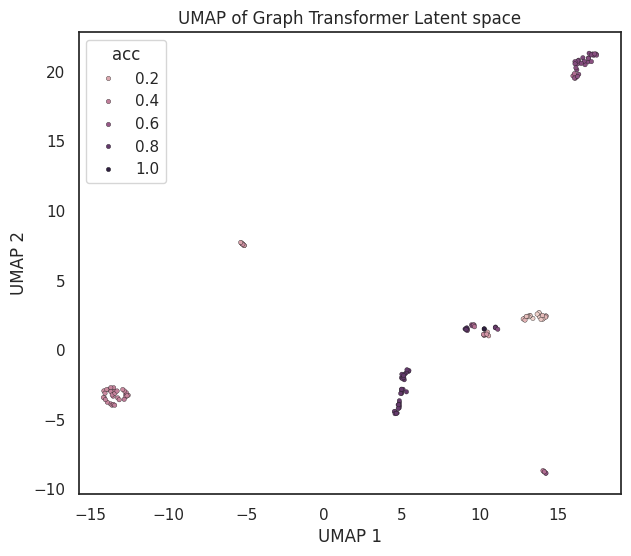

In [13]:
# Plotting
sns.set_theme(style='white')

plt.figure(figsize=(7, 6))
hue_metric = 'acc'
scatter = sns.scatterplot(data=df, x='embed_x', y='embed_y', 
            hue=hue_metric, s=10, edgecolor='k')
plt.legend(title=hue_metric)
plt.title("UMAP of Graph Transformer Latent space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

figure_dir = Path('results/evo-unconditional-encoder/figures')
figure_dir.mkdir(parents=True, exist_ok=True)

output_fig_path = figure_dir / Path(f'umap_{hue_metric}_run{run}.png')
plt.savefig(output_fig_path, bbox_inches='tight')

#### Regression test

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

target = input_labels

# 1. Split into new train/test sets for probing
X_train, X_test, y_train, y_test = train_test_split(
    lt_graph, target, test_size=0.3, random_state=42
)

# 2. Fit a linear regression model on the frozen embeddings
reg = LinearRegression()
reg.fit(X_train, y_train)

# 3. Evaluate on test set
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear probe regression metrics:")
print(f"  MSE: {mse:.4f}")
print(f"  R²:  {r2:.4f}")

Linear probe regression metrics:
  MSE: 0.0010
  R²:  0.9854


In [15]:
# Null Experiment 
target = df['amp']

# 1. Shuffle the targets randomly to break correlation
np.random.seed(42)
shuffled_targets = np.random.permutation(target)

# 2. Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(
    lt_graph, shuffled_targets, test_size=0.3, random_state=42
)

# 3. Train the same linear regressor on embeddings, but predict shuffled targets
reg_null = LinearRegression()
reg_null.fit(X_train, y_train)
y_pred_null = reg_null.predict(X_test)

# 4. Evaluate
mse_null = mean_squared_error(y_test, y_pred_null)
r2_null = r2_score(y_test, y_pred_null)


print("Null regression probe (randomized target):")
print(f"  MSE: {mse_null:.4f}")
print(f"  R²:  {r2_null:.4f}")


Null regression probe (randomized target):
  MSE: 0.0921
  R²:  -0.5794


#### Gaussian Test

In [17]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5).fit(lt_graph.numpy())
print("BIC:", gmm.bic(lt_graph.numpy())) # Lower BIC score is better


BIC: -20004.888501272857


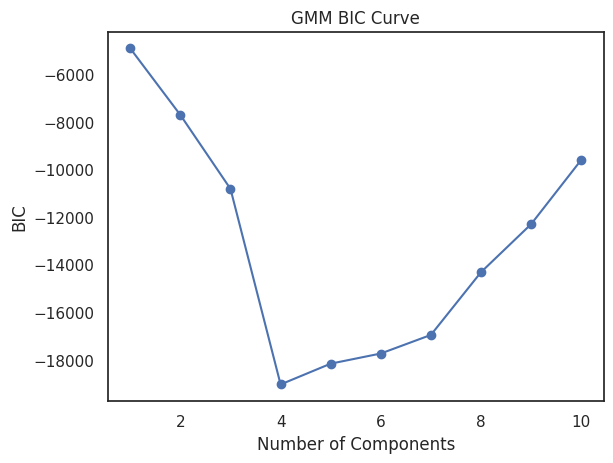

In [19]:
# Check modality of latent space 
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

BICs = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k).fit(lt_graph.numpy())
    BICs.append(gmm.bic(lt_graph.numpy()))

plt.plot(range(1, 11), BICs, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("GMM BIC Curve")
plt.show()
